In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Dataset/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')
data = data.set_index('Timestamp')
data['price'] = (data['Low'] + data['High'])/2
data.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,price
Timestamp,,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,4.39
2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data = data.resample('6H').mean()
data_nan = data.dropna()
data_nan.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,price
Timestamp,,,,,,,,
2011-12-31 06:00:00,4.39,4.390000,4.39,4.390000,0.455581,2.000000,4.390000,4.390000
2011-12-31 12:00:00,4.49,4.513333,4.49,4.513333,31.620766,141.106779,4.498804,4.501667
2012-01-01 00:00:00,4.58,4.580000,4.58,4.580000,1.502000,6.879160,4.580000,4.580000
2012-01-01 12:00:00,4.84,4.840000,4.84,4.840000,10.000000,48.400000,4.840000,4.840000
2012-01-01 18:00:00,5.00,5.000000,5.00,5.000000,10.100000,50.500000,5.000000,5.000000


In [ ]:
prediction_days = 500
data_train = data_nan['price'][:len(data_nan['price'])-prediction_days].values.reshape(-1,1)
data_test = data_nan['price'][len(data_nan['price'])-prediction_days:].values.reshape(-1,1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaled_data = MinMaxScaler(feature_range=(0,1))
scaled_train_data = scaled_data.fit_transform(data_train)
scaled_test_data = scaled_data.fit_transform(data_test)

In [ ]:
def create_dataset(dataset, look_back=30):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

train_x,train_y = create_dataset(scaled_train_data)
test_x,test_y = create_dataset(scaled_test_data)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(12846, 30)
(470, 30)
(12846,)
(470,)


In [ ]:
train_x = np.reshape(train_x,(train_x.shape[0],1,train_x.shape[1]))
test_x = np.reshape(test_x,(test_x.shape[0],1,test_x.shape[1]))
print(train_x.shape)
print(test_x.shape)

(12846, 1, 30)
(470, 1, 30)


In [ ]:
!pip install keras_tuner

     |████████████████████████████████| 97 kB 2.5 MB/s 


In [ ]:
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM

def model_builder(hp):
  model = Sequential()
  model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True,input_shape=(train_x.shape[1],train_x.shape[2])))
  for i in range(hp.Int('n_layers',1,4)):
    model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
  model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
  model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.05)))
  model.add(Dense(30, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
  model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.05)))
  model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
   
  model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    
  return model    

In [ ]:
tuner = kt.RandomSearch(model_builder, objective="mse", max_trials = 3, executions_per_trial =1,directory = "./")

tuner.search(x=train_x, y=train_y, epochs = 150, batch_size =128, validation_data=(test_x, test_y), shuffle=False)

Trial 3 Complete [00h 15m 27s]
mse: 0.07578345388174057

Best mse So Far: 0.011061526834964752
Total elapsed time: 00h 57m 24s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
input_unit: 448
n_layers: 3
lstm_0_units: 224
layer_2_neurons: 480
Dropout_rate: 0.05
dense_activation: sigmoid
lstm_1_units: 160
lstm_2_units: 384
Score: 0.011061526834964752
Trial summary
Hyperparameters:
input_unit: 384
n_layers: 3
lstm_0_units: 256
layer_2_neurons: 384
Dropout_rate: 0.45
dense_activation: relu
lstm_1_units: 32
lstm_2_units: 32
Score: 0.07578345388174057
Trial summary
Hyperparameters:
input_unit: 96
n_layers: 1
lstm_0_units: 352
layer_2_neurons: 448
Dropout_rate: 0.5
dense_activation: relu
lstm_1_units: 320
lstm_2_units: 352
Score: 0.07578345388174057


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
history = best_model.fit(x=train_x, y=train_y, epochs = 150, batch_size =128, validation_data=(test_x, test_y), shuffle=False, verbose=0)

In [ ]:
history

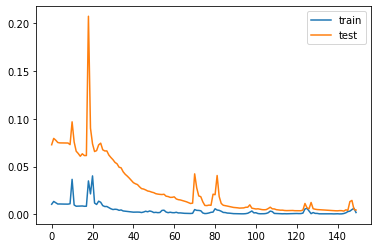

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
predicted_BTC_price = best_model.predict(test_x)

In [ ]:
predicted_BTC_price = scaled_data.inverse_transform(predicted_BTC_price.reshape(-1, 1))

In [ ]:
true = scaled_data.inverse_transform(test_y.reshape(-1, 1))

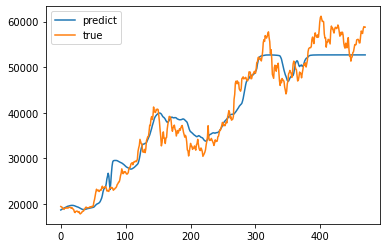

In [ ]:
plt.plot(predicted_BTC_price, label='predict')
plt.plot(true, label='true')
plt.legend()
plt.show()